In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.gridspec as gridspec
import xarray as xr
from matplotlib.pyplot import cm 

# %matplotlib notebook

In [2]:
analysis_dir = Path(r"C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis")

# save_dir  = Path(r"C:\Users\mvand\Documents\Master EE\Year 4\Thesis\meetings\2021_06_28_GL\new_media")
# save_dir = Path(r"C:\Users\mvand\Documents\Master EE\Year 4\Thesis\report\GL\imagery\min_max_results")

In [3]:
## collect files 
files = [file for file in analysis_dir.glob('*.csv')] 

bench_files = [file for file in files if 'benchmark_train' in file.stem]
train_files = [file for file in files if 'algorithm' in file.stem]

performance_cols = ['precision', 'recall', 'f1', 'balanced_acc']
confusion_cols = ['n', 'N', 'TP', 'TN', 'FP', 'FN']

In [4]:
## set buffer_size
buffer_size = 1

## get benchmark data 
bench_file = [file for file in bench_files if str(int(buffer_size)) in file.stem][0]

df_bench = pd.read_csv(bench_file, index_col=0)

df_bench['pca_level']='null'
df_bench['format'] = 'benchmark'

## get analysis data 
analysis_file = [file for file in train_files if str(int(buffer_size)) in file.stem][0]

## load analysis data 
df_analysis = pd.read_csv(analysis_file)

df_analysis.loc[ df_analysis['pca_level'].isnull(), 'pca_level'] = 'null'
df_analysis_single = df_analysis[df_analysis['format']=='single']
df_analysis_grid = df_analysis[df_analysis['format']=='grid']
 
## combine datasources 
df_stats_1 = df_analysis.append(df_bench)

In [5]:

def display_bar_stats(df, data_format, display_vars, 
                      out_dir=None, fn_stem = None):
        
    df_bench = df[df['format']=='benchmark'].groupby(by='model')[display_vars].sum() 
    
    df_stat = df[df['format']==data_format]
    
    n_algorithms = np.sort( df_stat['model'].unique() )
    n_PCA = df_stat['pca_level'].unique()
    
#     print(np.sort(n_algorithms))

    
    df_stat_mean = df_stat.groupby(by=['model', 'pca_level'])[display_vars].mean()
    df_stat_sum = df_stat.groupby(by=['model', 'pca_level'])[display_vars].sum()
    df_stat_min = df_stat.groupby(by=['model', 'pca_level'])[display_vars].min()
    df_stat_max = df_stat.groupby(by=['model', 'pca_level'])[display_vars].max() 
        
    if 'single' in data_format:
        data_format = 'Single Cell'
    if 'grid' in data_format:
        data_format = 'Window'
    
    for variable in display_vars:
        
        fig = plt.figure(figsize=(14,4))
        x_plot = 0. 
        
        x_tick_loc = []
        x_tick_label = [] 
        
        if variable not in ['TP', 'TN', 'FP', 'FN']:
            plt.title(f'{data_format.capitalize()} format - {variable.capitalize()}', size=16);
        else:
            plt.title(f'{data_format.capitalize()} format - {variable}', size=16);
            
        for algorithm in df_bench.index:
            plt.bar(x_plot, df_bench.loc[algorithm, variable], width=3, 
                   color='grey', label='Benchmark')
            
            x_tick_loc.append(x_plot)
            x_tick_label.append(algorithm)
            
            x_plot += 3.5
            
        x_plot += 4 
        
        select_cmap = cm.cubehelix(np.linspace(0,0.8, df_stat['pca_level'].nunique() ) )
        
        for algorithm in n_algorithms:
            
            for npc, n_pca in enumerate(n_PCA):
                
                if isinstance(n_pca, str):
                    plot_color = 'dimgrey'
                    label = 'no PCA'
                    x_tick_loc.append( (x_plot + 1.47*df_stat['pca_level'].nunique()) )
                    x_tick_label.append(algorithm.split('-')[0])
                    
                else:
                    plot_color = select_cmap[npc]
                    label = f'{int(n_pca*100)} % PCA'
                
                
                if variable not in ['TP', 'TN', 'FP', 'FN']:
                    
                    err_min = df_stat_mean.loc[algorithm, n_pca][variable] - df_stat_min.loc[algorithm, n_pca][variable]
                    err_max = df_stat_max.loc[algorithm, n_pca][variable] - df_stat_mean.loc[algorithm, n_pca][variable]
                    y_err = np.array([[err_min], [err_max]])
                                        
                    plt.bar(x_plot, df_stat_mean.loc[algorithm, n_pca][variable], 
                            width=3, color = plot_color, yerr=y_err, label = label)
                
                else:
                    err_min = df_stat_sum.loc[algorithm, n_pca][variable] - df_stat_min.loc[algorithm, n_pca][variable]
                    err_max = df_stat_max.loc[algorithm, n_pca][variable] - df_stat_sum.loc[algorithm, n_pca][variable]
                    y_err = np.array([[err_min], [err_max]])
                    
                    plt.bar(x_plot, df_stat_sum.loc[algorithm, n_pca][variable], 
                            width=3, color = plot_color , label = label)
                
                x_plot += 3.5
                                
            x_plot += 4 
            
        if variable not in ['TP', 'TN', 'FP', 'FN']:
            plt.ylim(0,1.05)
            plt.yticks(np.arange(0, 1.05, 0.1), ['{:.1f}'.format(v) for v in np.arange(0, 1.05, 0.1)])
        
        plt.grid() 
        plt.xticks(x_tick_loc, x_tick_label, size=14, rotation=50)
              
        handles, labels = plt.gca().get_legend_handles_labels() 
        by_label = dict(zip(labels, handles))
        
        plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.75, -0.3), fontsize=14,
                  ncol=4)
    
        plt.xlim(-2, x_plot-1)
        plt.tight_layout()

        if out_dir != None:
            if fn_stem == None:
                fn = out_dir / 'plot_{}_{}.png'.format(''.join(data_format.split()), variable)
            else:
                fn = out_dir / 'plot_{}_{}.png'.format(fn_stem, variable)
            print(fn)
#             plt.savefig(fn)
    
    return 

# labels = ['no PCA', '60%', '70%', '80%', '90%', '95%', '99%']

C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis\plot_minSW_single_precision.png
C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis\plot_minSW_single_recall.png
C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis\plot_minSW_single_f1.png
C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis\plot_minSW_single_balanced_acc.png


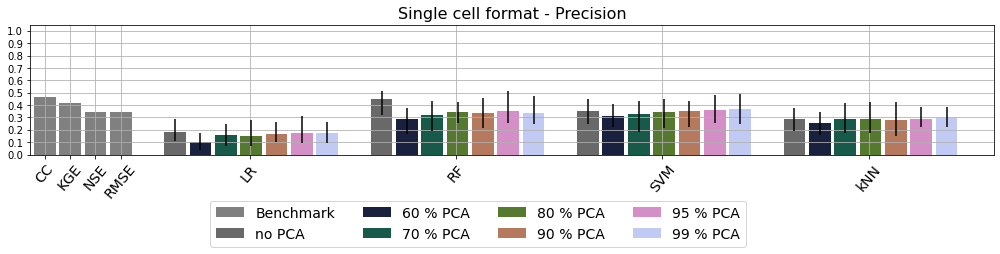

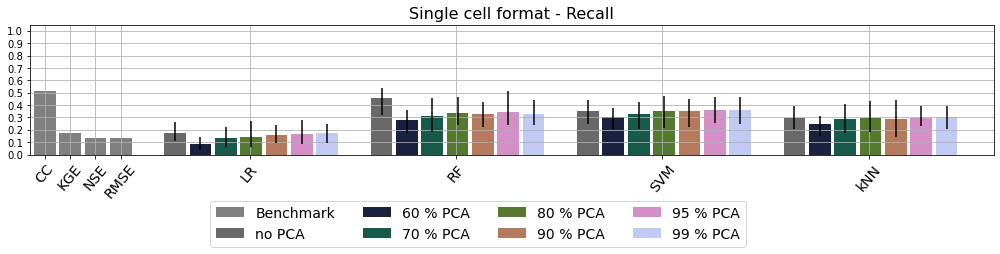

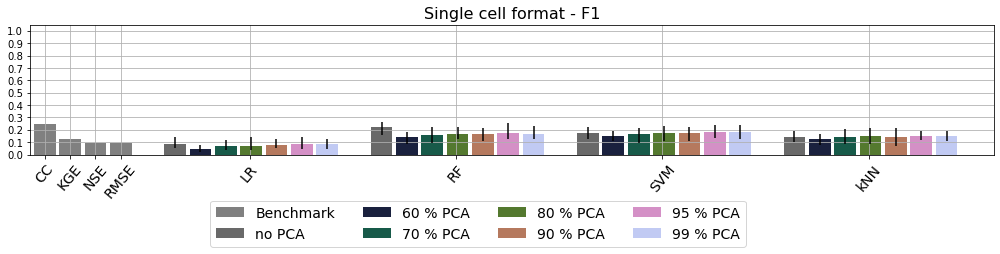

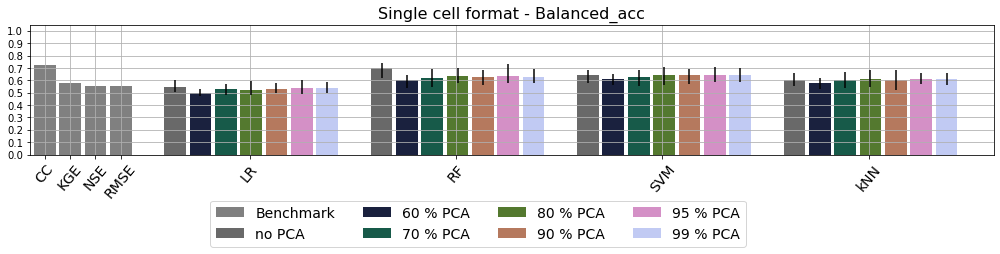

In [6]:
display_bar_stats(df_stats_1, data_format='single',
                  display_vars=performance_cols,
#                   display_vars = confusion_cols[2:], 
                  out_dir = analysis_dir, fn_stem = 'minSW_single')

C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis\plot_minSW_grid_precision.png
C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis\plot_minSW_grid_recall.png
C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis\plot_minSW_grid_f1.png
C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis\plot_minSW_grid_balanced_acc.png


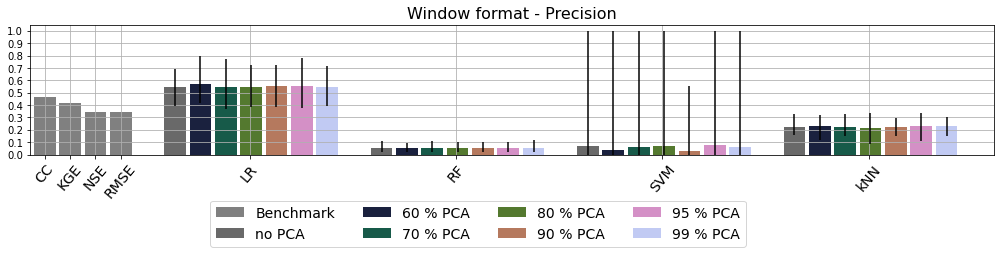

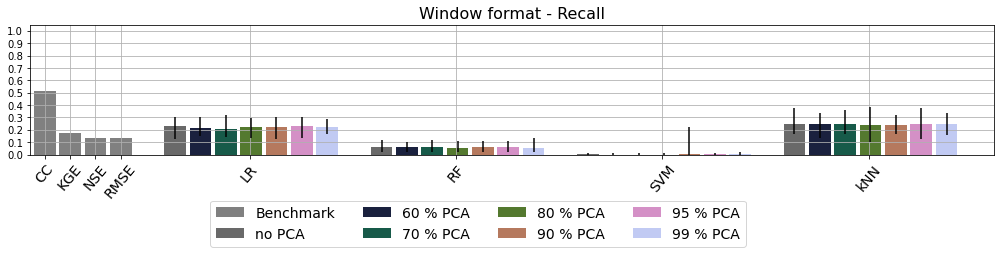

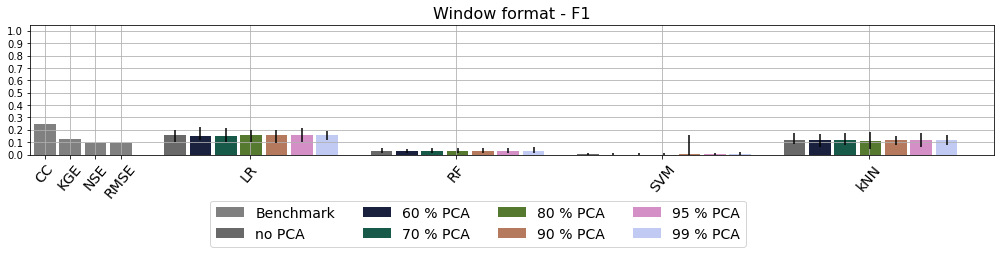

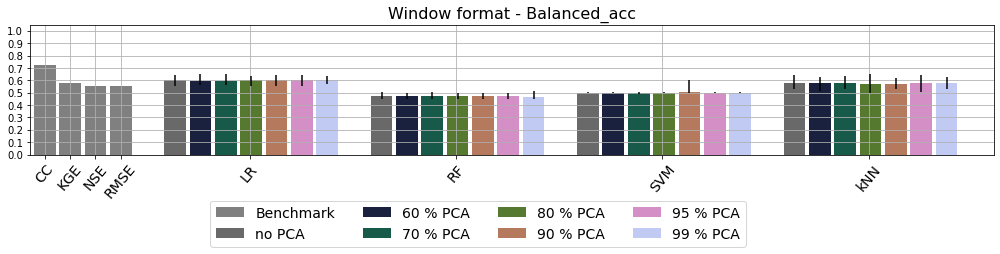

In [7]:
display_bar_stats(df_stats_1, data_format='grid',
                  display_vars=performance_cols,
#                   display_vars = confusion_cols[2:], 
                  out_dir = analysis_dir, fn_stem = 'minSW_grid')

In [8]:
df_stats_1.groupby(by=['pca_level', 'format', 'model'])[performance_cols].mean()

precision    recall        f1  balanced_acc
pca_level format    model                                                  
0.6       grid      LR-grid      0.568211  0.212057  0.153891      0.596904
                    RF-grid      0.053493  0.058858  0.028019      0.470941
                    SVM-grid     0.040000  0.000437  0.000433      0.500120
                    kNN-grid     0.227994  0.250607  0.119360      0.577601
          single    LR-single    0.102912  0.086684  0.047000      0.501023
                    RF-single    0.284604  0.277667  0.140467      0.599462
                    SVM-single   0.315763  0.301178  0.154047      0.613791
                    kNN-single   0.252499  0.246845  0.124749      0.582238
0.7       grid      LR-grid      0.548801  0.210667  0.151290      0.595437
                    RF-grid      0.053873  0.059294  0.028221      0.471182
                    SVM-grid     0.060000  0.000662  0.000655      0.500074
                    kNN-grid     0.224422  0.247030  0.117563      0.575590
          single    LR-single    0.154656  0.137295  0.072642      0.526399
                    RF-single    0.318343  0.312646  0.157644      0.618672
                    SVM-single   0.331475  0.326926  0.164502      0.626297
                    kNN-single   0.284573  0.286839  0.142795      0.602764
0.8       grid      LR-grid      0.548492  0.222456  0.157679      0.600859
                    RF-grid      0.051661  0.056875  0.027066      0.469836
                    SVM-grid     0.070000  0.000880  0.000868      0.500219
                    kNN-grid     0.215301  0.237070  0.112807      0.570046
          single    LR-single    0.149055  0.140281  0.072216      0.525084
                    RF-single    0.341153  0.337451  0.169525      0.632141
                    SVM-single   0.347567  0.354313  0.175353      0.639748
                    kNN-single   0.290289  0.297704  0.146897      0.607816
0.9       grid      LR-grid      0.551712  0.223612  0.158455      0.601511
                    RF-grid      0.052293  0.057731  0.027432      0.470302
                    SVM-grid     0.029111  0.005053  0.003779      0.502193
                    kNN-grid     0.220685  0.243210  0.115676      0.573447
          single    LR-single    0.163622  0.157170  0.080110      0.533242
                    RF-single    0.332145  0.324415  0.164033      0.625419
                    SVM-single   0.350147  0.352965  0.175691      0.639547
                    kNN-single   0.282943  0.291408  0.143503      0.604147
0.95      grid      LR-grid      0.551330  0.229522  0.161461      0.604183
                    RF-grid      0.052895  0.058343  0.027736      0.470645
                    SVM-grid     0.076667  0.001079  0.001060      0.500355
                    kNN-grid     0.227834  0.250480  0.119283      0.577528
          single    LR-single    0.177041  0.169760  0.086605      0.540289
                    RF-single    0.355982  0.344344  0.174922      0.637066
                    SVM-single   0.363546  0.364180  0.181856      0.646228
                    kNN-single   0.291476  0.299085  0.147567      0.608565
0.99      grid      LR-grid      0.547658  0.226583  0.159664      0.602655
                    RF-grid      0.050319  0.055566  0.026401      0.469097
                    SVM-grid     0.058000  0.001744  0.001681      0.500626
                    kNN-grid     0.227705  0.250515  0.119261      0.577536
          single    LR-single    0.178455  0.171743  0.087470      0.541279
                    RF-single    0.339261  0.330411  0.167283      0.628906
                    SVM-single   0.365462  0.363622  0.182159      0.646201
                    kNN-single   0.295302  0.303205  0.149550      0.610887
null      benchmark CC           0.465209  0.512035  0.243750      0.722857
                    KGE          0.417526  0.177243  0.124424      0.574691
                    NSE          0.346369  0.135667  0.097484      0.553411
    

In [9]:
buffer_size = 4
bench_file = [file for file in bench_files if str(int(buffer_size)) in file.stem][0]
analysis_file = [file for file in train_files if str(int(buffer_size)) in file.stem][0]

## load benchmark data 
df_bench = pd.read_csv(bench_file, index_col=0)

df_bench['pca_level']='null'
df_bench['format'] = 'benchmark'

## load analysis data 
df_analysis = pd.read_csv(analysis_file)

df_analysis.loc[ df_analysis['pca_level'].isnull(), 'pca_level'] = 'null'
df_analysis_single = df_analysis[df_analysis['format']=='single']
df_analysis_grid = df_analysis[df_analysis['format']=='grid']

df_stats_4 = df_analysis.append(df_bench)

C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis\plot_maxSW_single_precision.png
C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis\plot_maxSW_single_recall.png
C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis\plot_maxSW_single_f1.png
C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis\plot_maxSW_single_balanced_acc.png


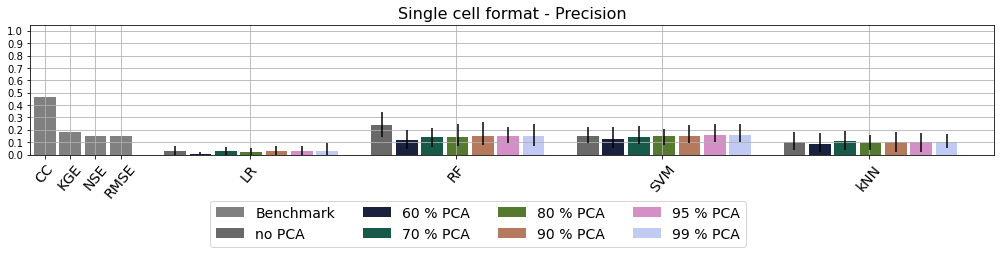

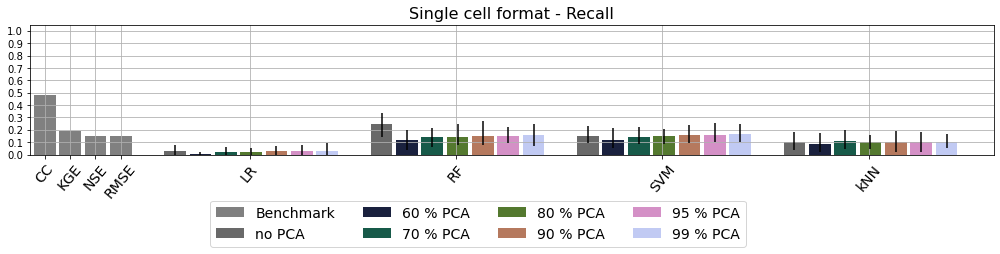

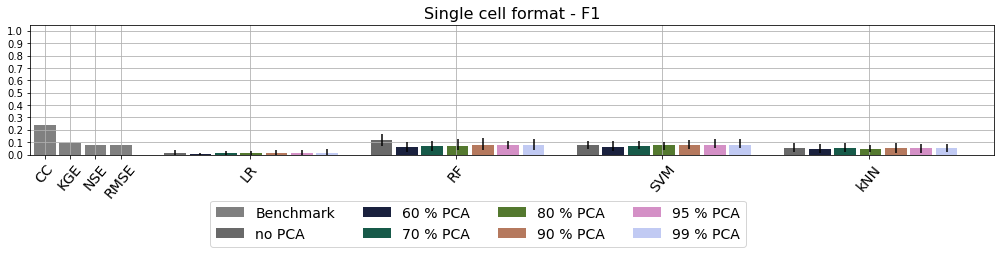

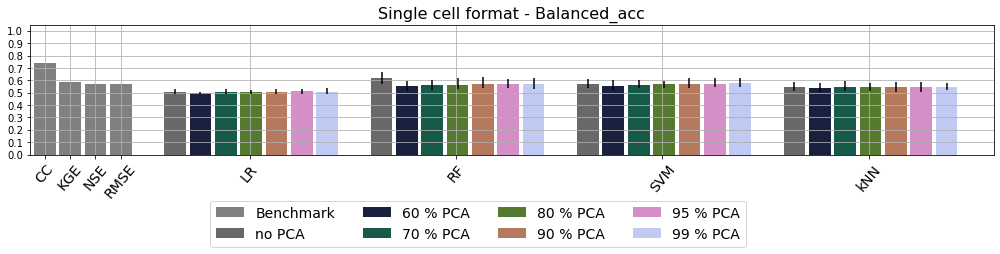

In [10]:
display_bar_stats(df_stats_4, data_format='single',
                  display_vars=performance_cols,
#                   display_vars = confusion_cols[2:], 
                  out_dir = analysis_dir, fn_stem = 'maxSW_single')

C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis\plot_maxSW_grid_precision.png
C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis\plot_maxSW_grid_recall.png
C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis\plot_maxSW_grid_f1.png
C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis\plot_maxSW_grid_balanced_acc.png


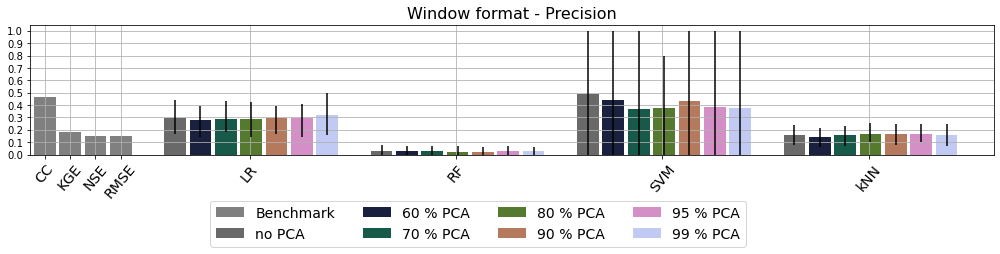

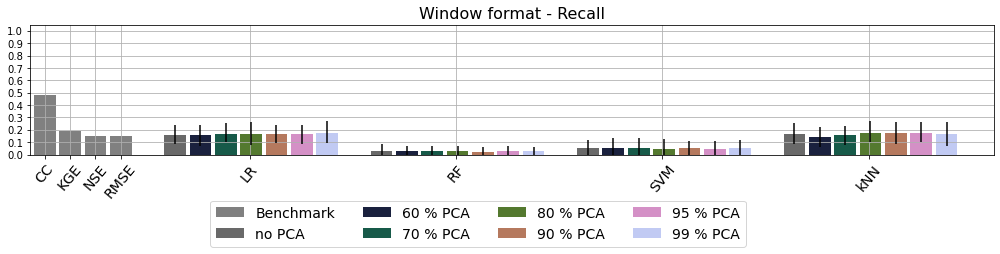

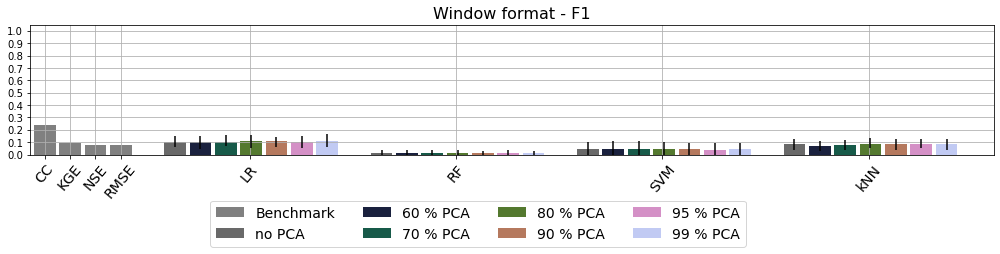

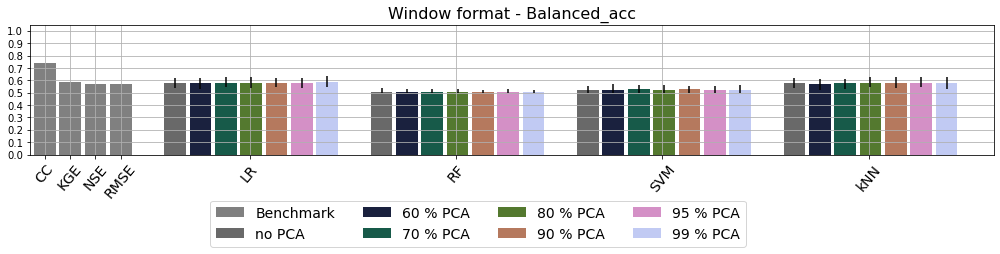

In [11]:
display_bar_stats(df_stats_4, data_format='grid',
                  display_vars=performance_cols,
#                   display_vars = confusion_cols[2:], 
                  out_dir = analysis_dir, fn_stem = 'maxSW_grid')

In [12]:
df_stats_4.groupby(by=['pca_level', 'format', 'model'])[performance_cols].mean()

precision    recall        f1  balanced_acc
pca_level format    model                                                  
0.6       grid      LR-grid      0.279913  0.157913  0.100757      0.576507
                    RF-grid      0.026642  0.027778  0.013598      0.507809
                    SVM-grid     0.437223  0.051667  0.045207      0.525450
                    kNN-grid     0.140343  0.145872  0.071520      0.567565
          single    LR-single    0.005597  0.005363  0.002738      0.496731
                    RF-single    0.119386  0.117490  0.059199      0.553344
                    SVM-single   0.126566  0.121595  0.061991      0.555563
                    kNN-single   0.087268  0.086733  0.043489      0.537726
0.7       grid      LR-grid      0.284821  0.164740  0.104075      0.579886
                    RF-grid      0.026624  0.027672  0.013568      0.507755
                    SVM-grid     0.371006  0.053440  0.045671      0.526265
                    kNN-grid     0.154465  0.160481  0.078702      0.574958
          single    LR-single    0.025292  0.024813  0.012522      0.506448
                    RF-single    0.140817  0.140748  0.070383      0.565014
                    SVM-single   0.139624  0.138620  0.069551      0.563976
                    kNN-single   0.107266  0.107879  0.053780      0.548336
0.8       grid      LR-grid      0.291467  0.169161  0.106799      0.582115
                    RF-grid      0.024657  0.025656  0.012571      0.506735
                    SVM-grid     0.379970  0.047554  0.041323      0.523392
                    kNN-grid     0.167792  0.174515  0.085534      0.582059
          single    LR-single    0.021484  0.021571  0.010762      0.504677
                    RF-single    0.141510  0.143290  0.071186      0.566230
                    SVM-single   0.151160  0.153553  0.076162      0.571403
                    kNN-single   0.096990  0.098593  0.048884      0.543573
0.9       grid      LR-grid      0.295414  0.167213  0.106496      0.581191
                    RF-grid      0.023469  0.024426  0.011968      0.506112
                    SVM-grid     0.436284  0.054931  0.047304      0.527028
                    kNN-grid     0.167618  0.174129  0.085399      0.581864
          single    LR-single    0.026385  0.026586  0.013241      0.507163
                    RF-single    0.148407  0.150383  0.074688      0.569813
                    SVM-single   0.152853  0.155484  0.077072      0.572369
                    kNN-single   0.101611  0.103568  0.051285      0.546073
0.95      grid      LR-grid      0.293218  0.164207  0.104988      0.579736
                    RF-grid      0.029816  0.031006  0.015198      0.509442
                    SVM-grid     0.381043  0.046515  0.039531      0.522817
                    kNN-grid     0.165606  0.172250  0.084425      0.580913
          single    LR-single    0.031661  0.032183  0.015958      0.509961
                    RF-single    0.149834  0.152682  0.075613      0.570938
                    SVM-single   0.156079  0.159252  0.078818      0.574256
                    kNN-single   0.100565  0.102723  0.050811      0.545637
0.99      grid      LR-grid      0.317421  0.173260  0.111657      0.584379
                    RF-grid      0.026030  0.027089  0.013274      0.507460
                    SVM-grid     0.373548  0.051775  0.044279      0.525404
                    kNN-grid     0.161459  0.167751  0.082268      0.578637
          single    LR-single    0.029278  0.029722  0.014746      0.508702
                    RF-single    0.151449  0.154632  0.076502      0.571915
                    SVM-single   0.159885  0.163321  0.080781      0.576313
                    kNN-single   0.100218  0.102080  0.050563      0.545321
null      benchmark CC           0.465209  0.483471  0.237082      0.738271
                    KGE          0.180915  0.188017  0.092198      0.588702
                    NSE          0.147117  0.152893  0.074974      0.570921
    

In [22]:
def plot_pareto(df_min, df_max, data_format,
               param_x, param_y,
                out_dir = None, fn_stem = None):
    
    ## select correct format 
    df_min_format = df_min[df_min['format']==data_format]
    df_max_format = df_max[df_max['format']==data_format]
    
    df_bench_min = df_min[df_min['format']=='benchmark']
    df_bench_max = df_max[df_min['format']=='benchmark']
    
    ## get data 
    plot_x_min = df_min_format.groupby(by=['model', 'pca_level'])[param_x].mean()
    plot_x_max = df_max_format.groupby(by=['model', 'pca_level'])[param_x].mean()
    
    plot_y_min = df_min_format.groupby(by=['model', 'pca_level'])[param_y].mean()
    plot_y_max = df_max_format.groupby(by=['model', 'pca_level'])[param_y].mean()
    
    bench_x_min = df_bench_min.groupby(by='model')[param_x].mean()
    bench_x_max = df_bench_max.groupby(by='model')[param_x].mean()
    
    bench_y_min = df_bench_min.groupby(by='model')[param_x].mean()
    bench_y_max = df_bench_max.groupby(by='model')[param_x].mean()   
    
    ## formatting ata for plots 
    n_markers = df_min_format['pca_level'].unique()
    n_algorithms = np.sort( df_min_format['model'].unique())
    
    select_cmap = cm.gnuplot(np.linspace(0., 0.9, len(n_algorithms) )) 
    show_markers = ["v", "^", "*", "s", "d", "p", ".", 'x']

    
    if 'grid' in data_format:
        set_title = 'Window'
    if 'single' in data_format:
        set_title = 'Single cell'
    
    plt.figure(figsize=(12,5))
    tl = plt.suptitle( f'{set_title} format', size=18)
    
    plt.subplot(121)
    plt.title('Minimum search window', size=16)
    plt.grid()
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel(param_x.capitalize(), size=16)
    plt.ylabel(param_y.capitalize(), size=16)
    plt.xticks(size=14)
    plt.yticks(size=14)
    
    plt.plot(bench_x_min.values, bench_y_min.values, lw=0., marker='o', markersize=10,
            label = 'Benchmark') 
    
    for i in range(len(bench_x_min)):
        x_label = bench_x_min.iloc[i] 
        y_label = bench_y_min.iloc[i]
        text_label = bench_x_min.index [i] 
        
        if 'CC' in text_label:
            dx = 0.03
            dy = 0.02
        if 'KGE'in text_label:
            dx = -0.15
            dy = 0.02
        if 'NSE' in text_label:
            dx = 0.03
            dy = -0.05
        if 'RMSE'in text_label:
            dx = -0.22
            dy = -0.05       
        plt.text(x_label+dx, y_label+dy, text_label, size=18)

    
    for m, m_alg in enumerate(n_algorithms):
        for n, n_pca in enumerate(n_markers):
            
            if isinstance(n_pca, str):
                set_label = 'no PCA'
            else:
                set_label = f'{int(100*n_pca)}%'
            
            plt.plot(plot_x_min.loc[m_alg, n_pca], plot_y_min.loc[m_alg, n_pca],
                    label = '{} - {}'.format(m_alg.split('-')[0], set_label),
                    lw = 0., marker = show_markers[n], color = select_cmap[m],
                    markersize=10)
            
    lgd = plt.legend(bbox_to_anchor=(2.4,-0.2), ncol=4, fontsize=18)            
    
    plt.subplot(122)
    plt.title('Maximum search window', size=16)
    plt.grid()
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel(param_x.capitalize(), size=16)
    plt.ylabel(param_y.capitalize(), size=16)
    plt.xticks(size=14)
    plt.yticks(size=14)    
    
    for m, m_alg in enumerate(n_algorithms):
        for n, n_pca in enumerate(n_markers):
            
            if isinstance(n_pca, str):
                set_label = 'no PCA'
            else:
                set_label = f'{int(100*n_pca)}%'
            
            plt.plot(plot_x_max.loc[m_alg, n_pca], plot_y_max.loc[m_alg, n_pca],
                    lw = 0., marker = show_markers[n], color = select_cmap[m],
                    markersize=10) 
            
    plt.plot(bench_x_max.values, bench_y_max.values, lw=0., marker='o', markersize=10)

    for i in range(len(bench_x_max)):
        x_label = bench_x_max.iloc[i] 
        y_label = bench_y_max.iloc[i]
        text_label = bench_x_max.index [i] 
        
        if 'CC' in text_label:
            dx = 0.03
            dy = 0.02
        if 'KGE'in text_label:
            dx = 0.02
            dy = 0.04
        if 'NSE' in text_label:
            dx = 0.03
            dy = -0.05
        if 'RMSE'in text_label:
            dx = -0.18
            dy = 0.03      
        plt.text(x_label+dx, y_label+dy, text_label, size=18)
    
    if out_dir != None:
        if fn_stem == None:
            fn = out_dir / 'plot_pareto.png'.format(col)
        else:
            fn = out_dir / 'plot_pareto_{}.png'.format(fn_stem)
        print(fn)
#         plt.savefig(fn, bbox_extra_artists=(lgd,tl,), bbox_inches='tight')
    
    return 

C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis\plot_pareto_grid.png


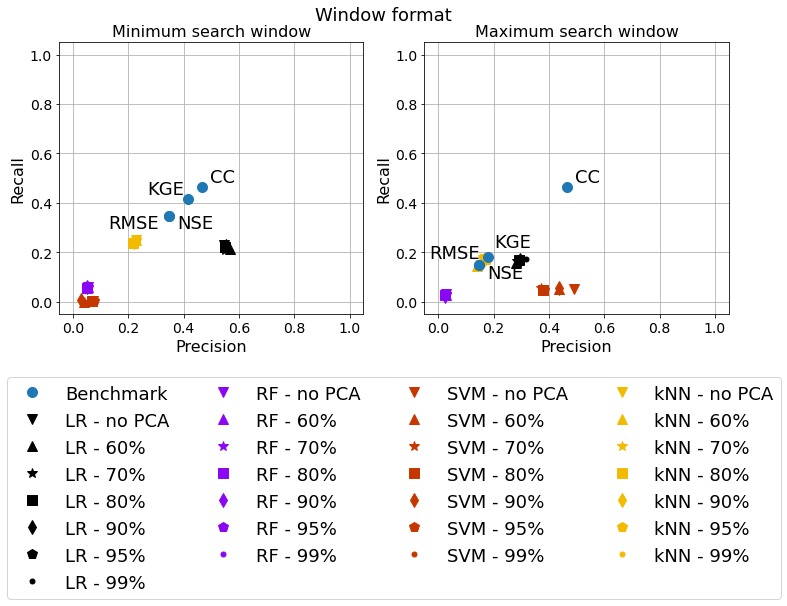

In [23]:
plot_pareto(df_stats_1, df_stats_4, 'grid', 'precision', 'recall',
           out_dir = analysis_dir, fn_stem = 'grid' )

C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis\plot_pareto_single.png


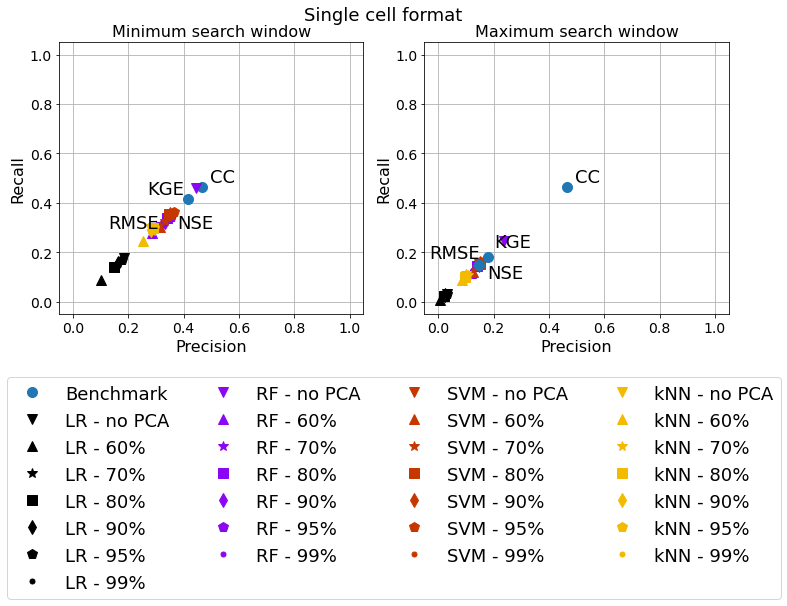

In [24]:
plot_pareto(df_stats_1, df_stats_4, 'single', 'precision', 'recall',
           out_dir = analysis_dir, fn_stem = 'single')

In [16]:
### load and display test results 

test_files = [file for file in files if 'test_stats' in file.stem]

test_bf1 = [file for file in test_files if '_1' in file.stem][0]
test_bf4 = [file for file in test_files if '_4' in file.stem][0]

df_test_bf1 = pd.read_csv(test_bf1)
df_test_bf1['sw'] = 1 

df_test_bf4 = pd.read_csv(test_bf4)
df_test_bf4['sw'] = 4 

df_test_stats = df_test_bf1.append(df_test_bf4)

In [17]:
df_test_stats.groupby(by=['sw', 'type', 'model'])[performance_cols].sum()

precision    recall        f1  balanced_acc
sw type      model                                                 
1  benchmark CC          0.467391  0.524390  0.247126      0.729353
             KGE         0.400000  0.170732  0.119658      0.571291
             NSE         0.472222  0.207317  0.144068      0.590924
             RMSE        0.472222  0.207317  0.144068      0.590924
   model     LR-grid     0.402174  0.451220  0.212643      0.688746
             RF-single   0.423913  0.475610  0.224138      0.702282
4  benchmark CC          0.467391  0.488636  0.238889      0.740937
             KGE         0.173913  0.181818  0.088889      0.585665
             NSE         0.195652  0.204545  0.100000      0.597166
             RMSE        0.195652  0.204545  0.100000      0.597166
   model     LR-grid     0.380435  0.397727  0.194444      0.694993
             RF-single   0.239130  0.250000  0.122222      0.620170

In [18]:
df_test_stats.groupby(by=['sw', 'type', 'model'])[confusion_cols].sum()

n     N  TP    TN  FP  FN
sw type      model                                
1  benchmark CC         82   828  43   697  49  39
             KGE        82   828  14   725  21  68
             NSE        82   828  17   727  19  65
             RMSE       82   828  17   727  19  65
   model     LR-grid    82   828  37   691  55  45
             RF-single  82   828  39   693  53  43
4  benchmark CC         88  7334  43  7197  49  45
             KGE        88  7334  16  7170  76  72
             NSE        88  7334  18  7172  74  70
             RMSE       88  7334  18  7172  74  70
   model     LR-grid    88  7452  35  7307  57  53
             RF-single  88  7334  22  7176  70  66